In [60]:
%load_ext autoreload
%autoreload 2

%pylab inline

from models import *
from utils import load_dataset, training_steps, evaluation_step
import yaml
import torch
from torch.utils.data import DataLoader
import math
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\yanne\anaconda3\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy', 'Generator', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
BS = 64
BS_test = 1000
with open('./parameters/VAE_MNIST.yaml', 'rb') as f:
    config = yaml.safe_load(f)

data, unnormalize, nb_classes = load_dataset(config)
dataloader = DataLoader(data, batch_size = BS, shuffle = True)

test_data, _, _ = load_dataset(config, training = False)
test_dataloader = DataLoader(test_data, batch_size = BS_test, shuffle = True)


In [21]:
batch, label = next(iter(test_dataloader))
batch = batch.to(device)

# VAE 3D

In [125]:
vae = VAE_3D(config, dataloader.dataset[0][0].shape, nb_classes)

vae = vae.to(device)

VAE epoch: 19.000 Loss: 4204.684: 100%|██████████| 938/938 [00:29<00:00, 32.12it/s]


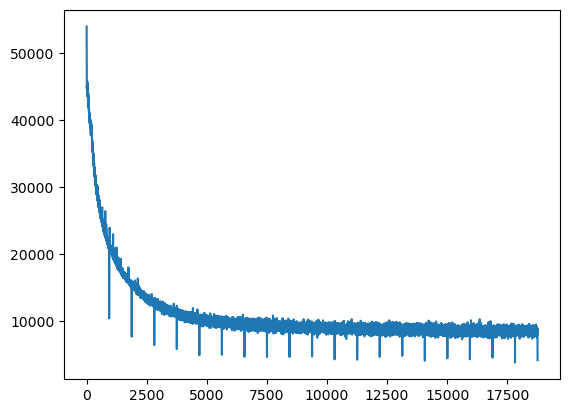

In [42]:
losses = training_steps(vae, dataloader,unnormalize)
plot(losses)

In [74]:
batch, label = next(iter(test_dataloader))
batch = batch.to(device)
vae.eval()
with torch.no_grad():
    out = vae(batch)
    loss_dict = vae.loss_function(out, batch, unnormalize)
loss_dict['loss'].item()/BS_test, loss_dict['kl_loss'].item()*config['optimization']['kl_weight']/BS_test 

(133.2559375, 0.0017533145904541016)

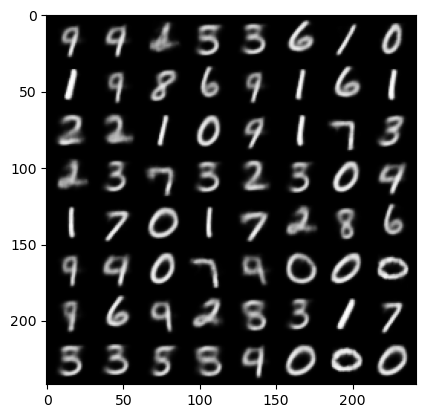

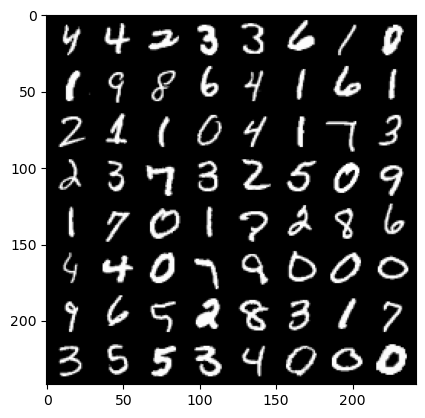

In [66]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

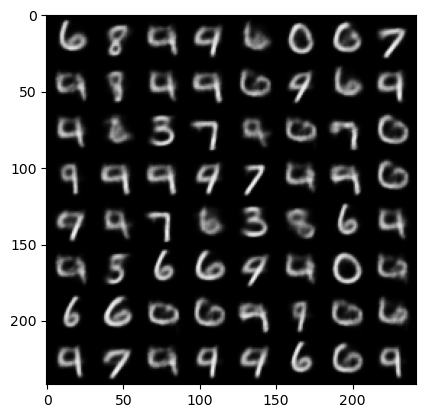

In [45]:
img_sampled = vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img_sampled).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

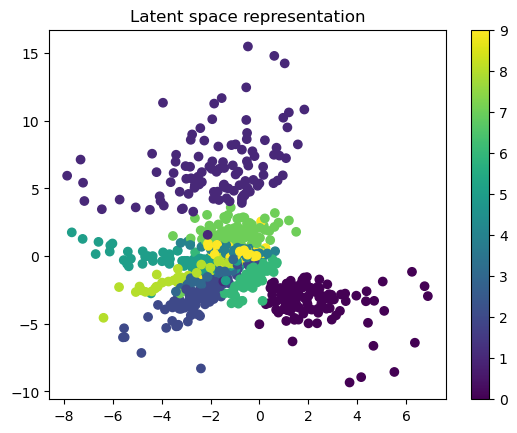

In [67]:
with torch.no_grad():
    mu, logvar = vae.encoder(batch.to(device))
    z = vae.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
title('Latent space representation')
colorbar()

# VAE complex

In [16]:
with open('./parameters/VAEcomplex_MNIST_params.yaml', 'rb') as f:
    config_complex = yaml.safe_load(f)
vae_complex = VAE_complex(config_complex, dataloader.dataset[0][0].shape, nb_classes)
vae_complex.to(device)
losses_complex = training_steps(vae_complex,dataloader, unnormalize)

VAE epoch: 19.000 Loss: 4409.863: 100%|██████████| 938/938 [00:29<00:00, 31.55it/s] 


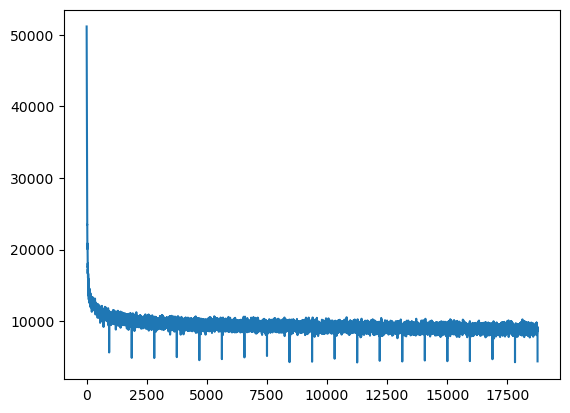

In [17]:
plot(losses_complex)

In [70]:
batch, label = next(iter(test_dataloader))
batch = batch.to(device)
vae_complex.eval()
with torch.no_grad():
    out = vae_complex(batch)

    loss_dict = vae_complex.loss_function(out, batch, unnormalize)
loss_dict['loss'].item()/BS_test, loss_dict['kl_loss'].item()*config['optimization']['kl_weight']/BS_test 

(137.080046875, 0.0017829652786254884)

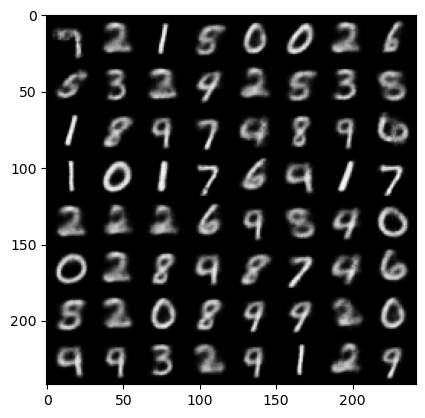

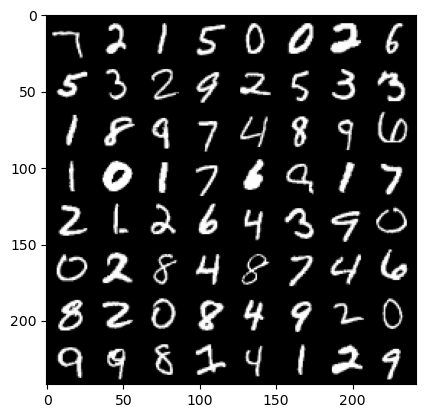

In [22]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu(), int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu(), int(math.sqrt(BS))).permute(1,2,0))


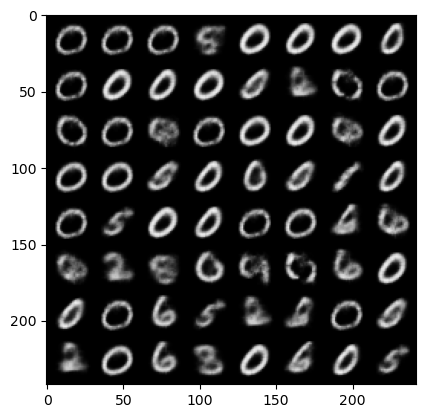

In [60]:
img_complex_samp = vae_complex.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img_complex_samp).cpu(), nrow = int(math.sqrt(BS))).permute(1,2,0))

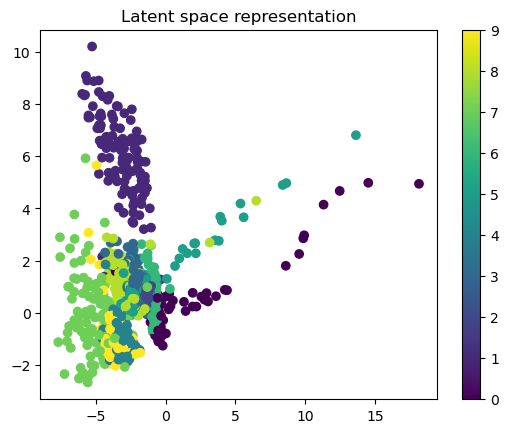

In [71]:
with torch.no_grad():
    mu, logvar = vae_complex.encoder(batch)
    z = vae_complex.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
title('Latent space representation')
colorbar()

### Sampling wasn't good, we can look at the above latent space representation and select a specific value for mu which leads to a sample corresponding to an adequate number

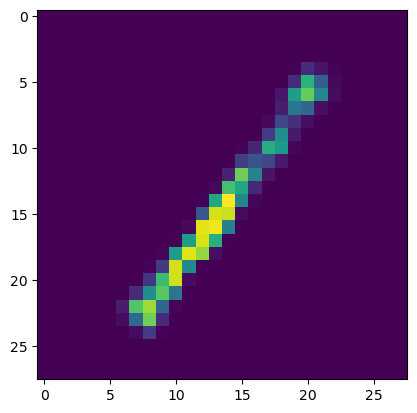

In [80]:
mu_complex = torch.tensor(np.array([-1,10])).unsqueeze(0).to(device)
logvar_complex = torch.ones((1,2)).to(device)

with torch.no_grad():
    img_complex = vae_complex.decoder(vae_complex.reparameterize(mu_complex, logvar_complex))

imshow(img_complex[0].cpu().permute(1,2,0))

# Multi-Stage VAE

In [35]:
with open('./parameters/multistage_vae_params.yaml', 'rb') as f:
    config_multi = yaml.safe_load(f)
multi_vae = MultiStage_VAE(config_multi, dataloader.dataset[0][0].shape, nb_classes)
multi_vae.to(device)
losses_multi = training_steps(multi_vae,dataloader, unnormalize)

VAE epoch: 19.000 Loss: 9511.006: 100%|██████████| 938/938 [00:31<00:00, 30.04it/s] 


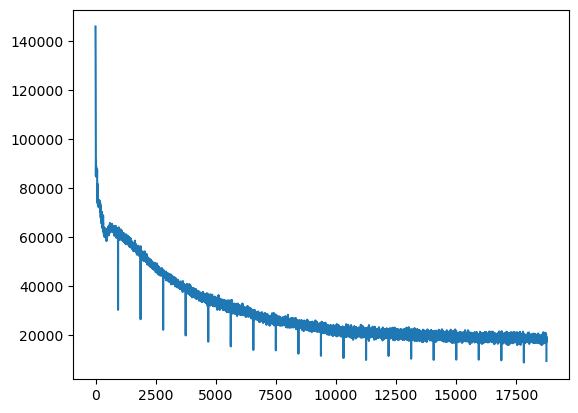

In [36]:
plot(losses_multi)

In [73]:
batch = next(iter(test_dataloader))[0].to(device)
multi_vae.eval()
with torch.no_grad():
    out = multi_vae(batch)
    loss_dict = multi_vae.loss_function(out, batch, unnormalize)
loss_dict['loss'].item()/BS_test, loss_dict['kl_loss'].item()*config['optimization']['kl_weight']/BS_test

(291.30709375, 0.0017873287200927735)

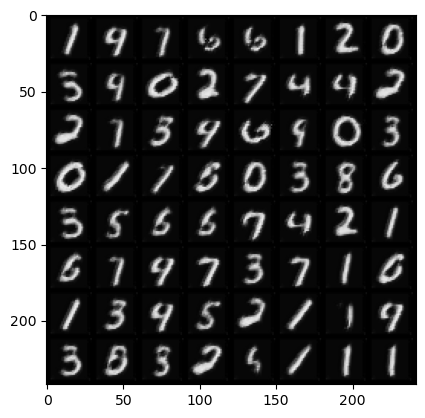

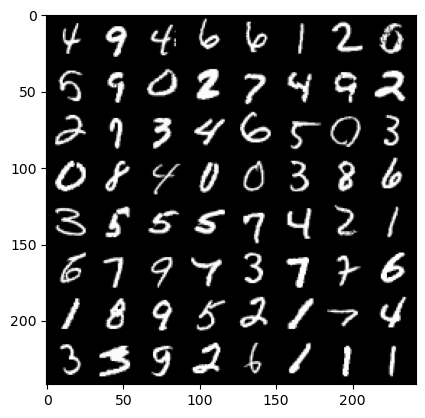

In [38]:
imshow(torchvision.utils.make_grid(unnormalize(out[0]).cpu(), int(math.sqrt(BS))).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch).cpu(), int(math.sqrt(BS))).permute(1,2,0))


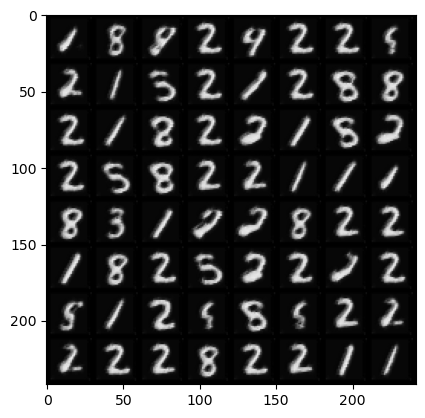

In [39]:
multi_img_samp = multi_vae.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(multi_img_samp).cpu(), int(math.sqrt(BS))).permute(1,2,0))


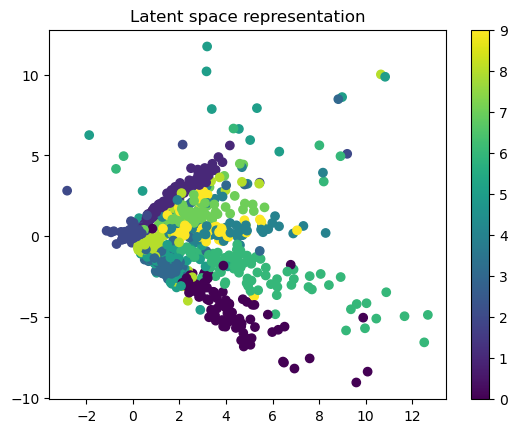

In [75]:
with torch.no_grad():
    mu, logvar = multi_vae.encoder(batch)
    z = multi_vae.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
title('Latent space representation')
colorbar()

# VQ-VAE

### PixelCNN latent generator

In [3]:
with open('./parameters/VQ_VAE_parameters.yaml') as f:
    config_vqvae = yaml.safe_load(f)

vq_vae = VQ_VAE(config_vqvae, dataloader.dataset[0][0].shape, nb_classes)
vq_vae = vq_vae.to(device)
losses_vqvae = training_steps(vq_vae, dataloader, unnormalize)

In [92]:
vq_vae.eval()
with torch.no_grad():
    out = vq_vae(batch)
    loss_dict = vq_vae.loss_function(out, batch, unnormalize)
loss_dict['loss'].item(), loss_dict['commitment_loss'].item()*vq_vae.optim_params['commitment_weight']

(0.12534968554973602, 0.01532549262046814)

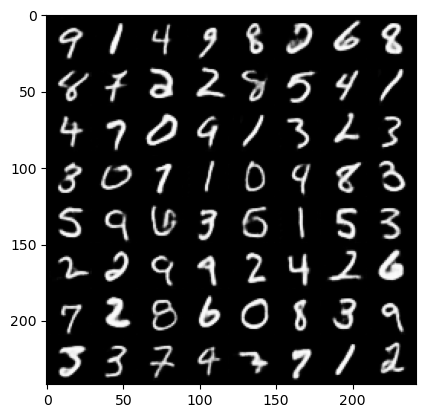

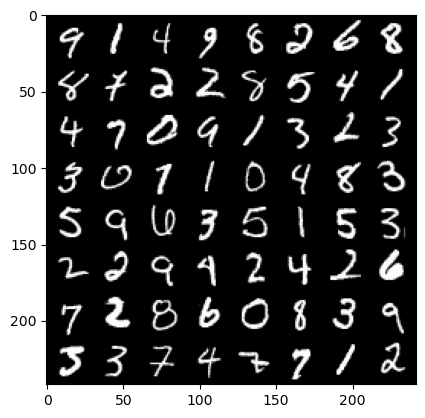

In [94]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS]).cpu()).permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS]).cpu()).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


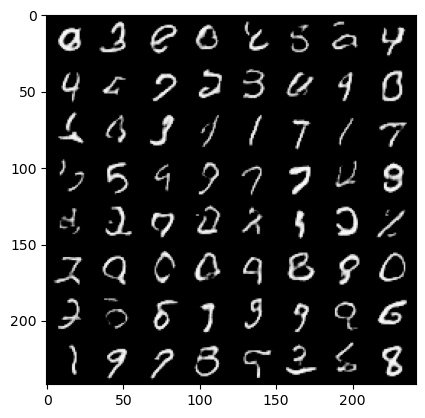

In [96]:
vqvae_sample = vq_vae.sample(BS)
imshow(torchvision.utils.make_grid(vqvae_sample.cpu()).permute(1,2,0))

### LSTM latent generator

In [52]:
with open('./parameters/VQ_VAE_parameters_LSTMprior.yaml') as f:
    config_vqvae_lstm = yaml.safe_load(f)

vq_vae_lstm = VQ_VAE(config_vqvae_lstm, dataloader.dataset[0][0].shape, nb_classes)
vq_vae_lstm = vq_vae_lstm.to(device)
losses_vqvae_lstm = training_steps(vq_vae_lstm, dataloader, unnormalize)

Generator epoch: 9.0, loss: 0.444: 100%|██████████| 3516/3516 [02:04<00:00, 28.23it/s]


In [53]:
vq_vae_lstm.eval()
with torch.no_grad():
    out = vq_vae_lstm(batch)
    loss_dict = vq_vae_lstm.loss_function(out, batch, unnormalize)
loss_dict

{'loss': tensor(0.1682),
 'recon_loss': tensor(0.0389),
 'commitment_loss': tensor(0.1077),
 'embed_loss': tensor(0.1077)}

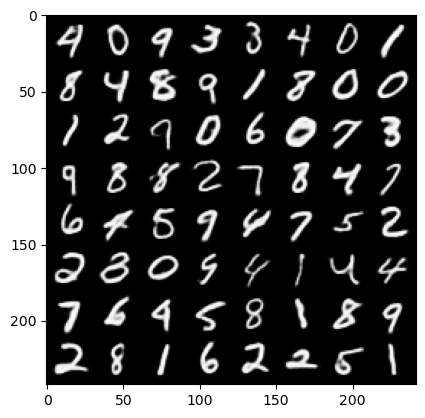

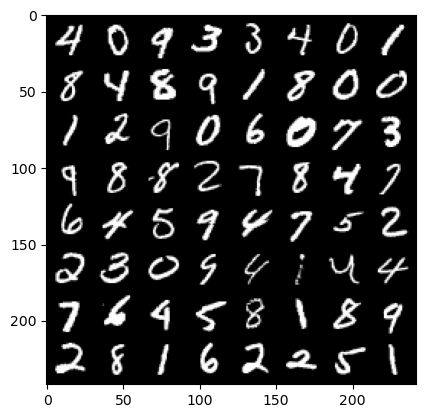

In [54]:
imshow(torchvision.utils.make_grid(unnormalize(out[0][:BS])).cpu().permute(1,2,0))
show()
imshow(torchvision.utils.make_grid(unnormalize(batch[:BS])).cpu().permute(1,2,0))

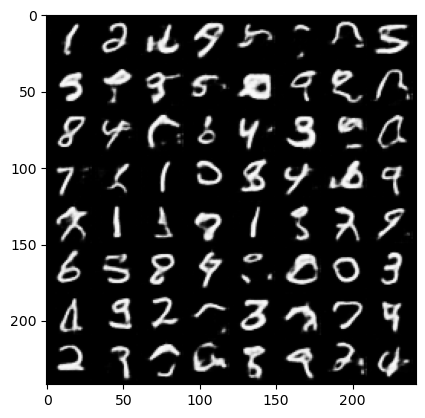

In [55]:
vqvae_lstm_sample = vq_vae_lstm.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(vqvae_lstm_sample).cpu()).permute(1,2,0))

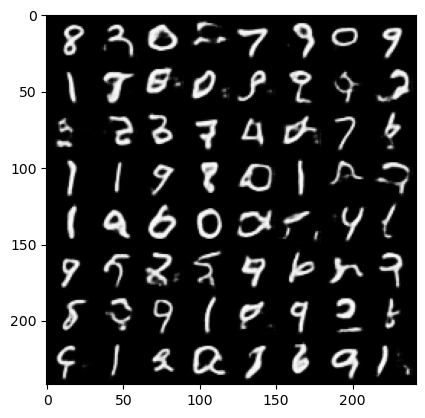

In [56]:
img = vq_vae_lstm.sample(BS)
imshow(torchvision.utils.make_grid(unnormalize(img).cpu()).permute(1,2,0))

# GAN

In [70]:
with open('./parameters/GAN_MNIST_params.yaml', 'rb') as f:
    config_gan = yaml.safe_load(f)

gan = GAN(config_gan, dataloader.dataset[0][0].shape, nb_classes)
gan = gan.to(device)

In [71]:
losses_gan = training_steps(gan, dataloader, unnormalize)

  0%|          | 0/938 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 28 but got size 224 for tensor number 1 in the list.